Recapitulating the model: Receptor downregulation and desensitization enhance the information processing ability of signalling receptors

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

The intial EGFR Model

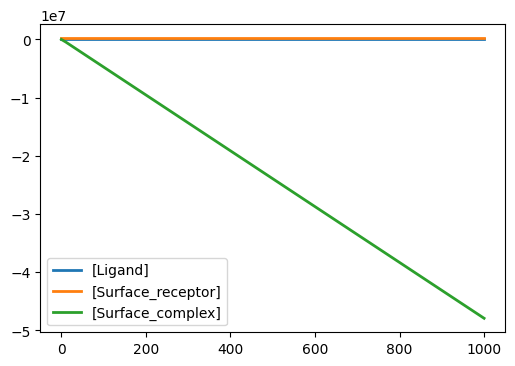

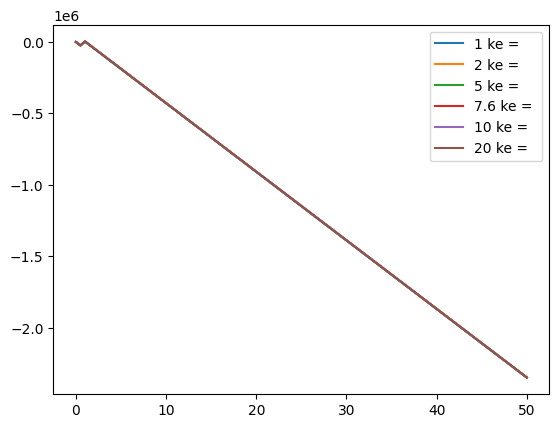

6


In [62]:
# seperate ligand and receptor entire EGFR model
shankaran_model_EGFR = te.loada("""

Ligand + Surface_receptor -> Surface_complex; Ligand*Surface_receptor*kon

Surface_complex -> Ligand; Surface_complex*koff*(1/(V*Nav))

Surface_complex -> ; Surface_receptor*koff

Surface_receptor = Rt
Surface_complex = 0

kon = 0.097
koff = 0.24
Kd = koff/kon
kt = 0.02
ke = 0.15
Vr = kt*Rt 

Rt = 200000
Nav = 6.022*10^23
V = 0.0000000004
at (time > 1): Surface_complex = Vr
at (time > 1): Ligand = 0.01*Kd
""")
shankaran_model_EGFR.reset()
m = shankaran_model_EGFR.simulate(0, 1000, 100)
shankaran_model_EGFR.plot()

# change a species value to recreate the graph
shankaran_model_EGFR.resetAll()
count = 0
for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 50, 100,['time','Surface_complex'])
    plt.plot(result[:,0],result[:,1], label = '%s ke = '%i) 
    count += 1

plt.legend()
plt.show()
print(count)

Manipulating the EGFR model 

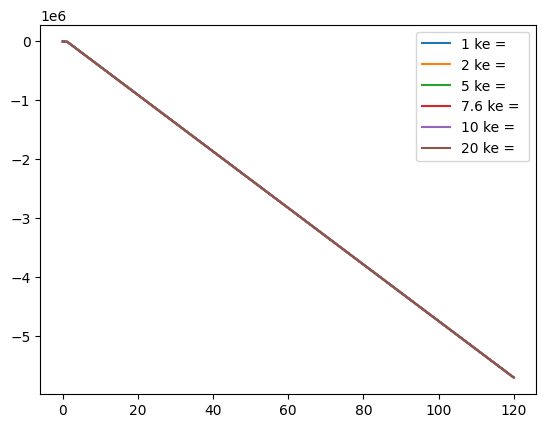

6


In [63]:
shankaran_model_EGFR.resetAll()
count = 0
for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 120, 100,['time','Surface_complex'])
    plt.plot(result[:,0],result[:,1], label = '%s ke = '%i) 
    count += 1

plt.legend()
plt.show()
print(count)

The GPCR Model

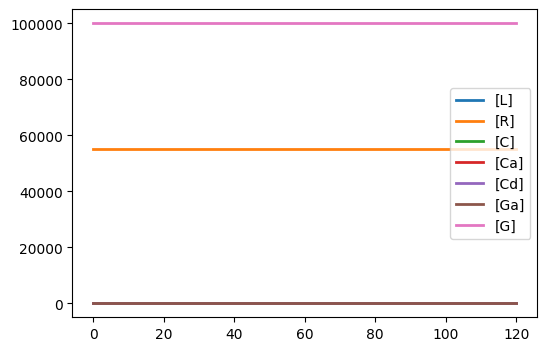

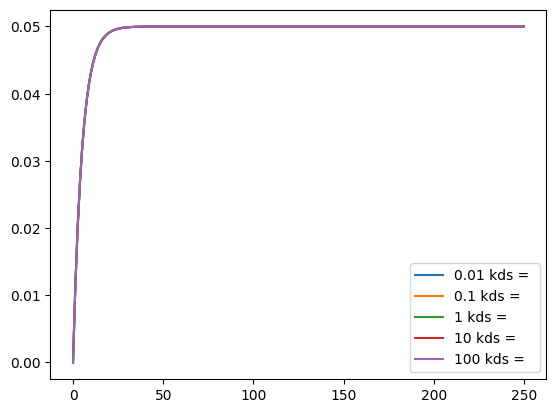

In [61]:
# seperate ligand and receptor GPCR
shankaran_model_GPCR = te.loada(""" 
L + R -> C; L*R*kon
C -> R; C*koff
C -> L; koff*(1/(V*Nav))*C

C -> Ca; C*kfr
Ca -> C; Ca*krr

Ca -> Cd; Ca*kds

Ga -> G; Ga*ki
G -> Ga; G*ka
Ca + G -> Ga; (Ca^2)*ka*G

R = RT
G = GT 
C = 0
Ca = 0
Cd =0
Ga = 0

kon = 84000000
koff = 0.37
Kd = koff/kon
kfr = 10
krr = 10
kds = 0.065
ka = 0.0000001
ki = 0.2

Nav = 6.022*10^23
V = 0.0000000004
RT = 55000 
GT = 100000

at (time > 1): L = 0.01*Kd
""")
shankaran_model_GPCR.resetToOrigin()
GPCR_model = shankaran_model_GPCR.simulate(0,120,100)
shankaran_model_GPCR.plot()

shankaran_model_GPCR.resetAll()
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.resetToOrigin()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 250, 200,['time','Ga'])
    plt.plot(result[:,0],result[:,1], label = '%s kds = ' %i)

plt.legend()
plt.show()

Manipulate the model and reproduce the graphs for the GPCR

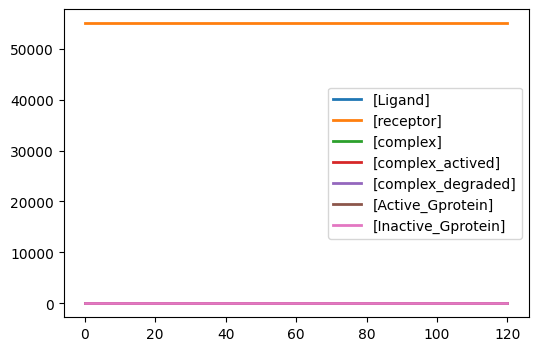

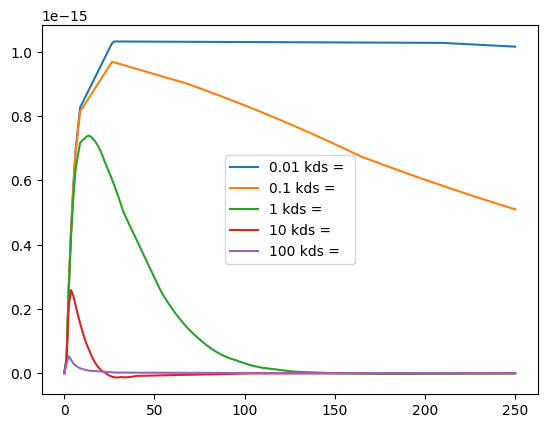

In [64]:
# seperate ligand and receptor GPCR
shankaran_model_GPCR = te.loada(""" 
Ligand + receptor -> complex; Ligand*receptor*kon
complex -> Ligand + receptor; complex*koff

Ligand + receptor -> complex; Ligand*receptor*kon
complex -> Ligand + receptor; complex*koff*(1/(Nav*V))

complex_actived -> complex; complex_actived*krr

complex -> complex_actived; complex*kfr

complex_actived -> complex_degraded; complex_actived*kds


Active_Gprotein -> Inactive_Gprotein + complex_actived; Active_Gprotein*ki
Inactive_Gprotein + complex_actived -> Active_Gprotein; (complex_actived)*Inactive_Gprotein*ka


receptor = RT
complex = 0
Active_Gprotein = 0
Inactive_Gprotein = 100000 /1000

kon = 8.4*10^7
koff = 0.37
Kd = koff/kon
kfr = 10
krr = 10
kds = 0.065
ka = 10^-7
ki =2*10^-1

Nav = 6.022*10^23
V = 4*10^4
RT = 5.5*10^4 
GT = 1*10^5 

at (time > 1): Ligand = 0.01*Kd

""")
shankaran_model_GPCR.resetToOrigin()
GPCR_model = shankaran_model_GPCR.simulate(0,120,100)
shankaran_model_GPCR.plot()

shankaran_model_GPCR.resetAll()
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.resetToOrigin()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 250, 200,['time','Active_Gprotein'])
    plt.plot(result[:,0],result[:,1], label = '%s kds = ' %i)

plt.legend()
plt.show()